In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import math
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
from sklearn.metrics import f1_score
plt.ion()   # interactive mode
from prefetch_generator import BackgroundGenerator
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


dat = pd.read_csv('srmj_labels.csv')
X = dat['X_numpy']
y = dat[['opp1_waiting_yes','opp1_waiting_no','opp2_waiting_yes',
        'opp2_waiting_no','opp3_waiting_yes','opp3_waiting_no',]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

print(y)
#train
opp1_waiting = ['opp1_waiting_yes','opp1_waiting_no']
opp1_waiting_train = y_train[opp1_waiting]
opp1_waiting_nodes = opp1_waiting_train.shape[1]
opp1_waiting_train = opp1_waiting_train.values.tolist()

opp2_waiting = ['opp2_waiting_yes','opp2_waiting_no']
opp2_waiting_train = y_train[opp2_waiting]
opp2_waiting_nodes = opp2_waiting_train.shape[1]
opp2_waiting_train = opp2_waiting_train.values.tolist()

opp3_waiting = ['opp3_waiting_yes','opp3_waiting_no']
opp3_waiting_train = y_train[opp3_waiting]
opp3_waiting_nodes = opp3_waiting_train.shape[1]
opp3_waiting_train = opp3_waiting_train.values.tolist()


print(opp1_waiting_nodes,opp2_waiting_nodes,opp3_waiting_nodes)

#test
opp1_waiting = ['opp1_waiting_yes','opp1_waiting_no']
opp1_waiting_test = y_test[opp1_waiting]
opp1_waiting_nodes = opp1_waiting_test.shape[1]
opp1_waiting_test = opp1_waiting_test.values.tolist()

opp2_waiting = ['opp2_waiting_yes','opp2_waiting_no']
opp2_waiting_test = y_test[opp2_waiting]
opp2_waiting_nodes = opp2_waiting_test.shape[1]
opp2_waiting_test = opp2_waiting_test.values.tolist()

opp3_waiting = ['opp3_waiting_yes','opp3_waiting_no']
opp3_waiting_test = y_test[opp3_waiting]
opp3_waiting_nodes = opp3_waiting_test.shape[1]
opp3_waiting_test = opp3_waiting_test.values.tolist()

print(opp1_waiting_nodes,opp2_waiting_nodes,opp3_waiting_nodes)

       opp1_waiting_yes  opp1_waiting_no  opp2_waiting_yes  opp2_waiting_no  \
0                     0                1                 1                0   
1                     0                1                 1                0   
2                     0                1                 1                0   
3                     1                0                 1                0   
4                     0                1                 0                1   
...                 ...              ...               ...              ...   
39995                 1                0                 1                0   
39996                 1                0                 0                1   
39997                 1                0                 0                1   
39998                 1                0                 0                1   
39999                 1                0                 0                1   

       opp3_waiting_yes  opp3_waiting_no  
0       

In [62]:
# numpy stack vstack hstack
# import numpy as np
# a=[[1,2,3],
#    [4,5,6]]
# b=[[1,2,3],
#    [4,5,6]]
# c=[[1,2,3],
#    [4,5,6]]
# print("a=",a)
# print("b=",b)
# print("c=",c)

# d=np.stack((a,b,c),axis=0)
# print('"axis=0":\n',d)

# d=np.stack((a,b,c),axis=1)
# print('"axis=1":\n',d)

# d=np.hstack((a,b,c))
# print('"axis=1":\n',d)


# d=np.stack((a,b,c),axis=2)
# print('"axis=2":\n',d)
# d

In [63]:
# pandas DataFrame
data = {
        '性别':['男','女','女','男','男'],
        '姓名':['小明','小红','小芳','大黑','张三'],
        '年龄':[20,21,25,24,29]}
df = pd.DataFrame(data,index=['one','two','three','four','five'],
               columns=['姓名','性别','年龄','职业'])
df

# df.iloc[,2] # 选择第二行所有数据, 是Series类型
# df.iloc[[2]] # 选择第二行所有数据, 是DataFrame类型
# df.iloc[:, 2] # 选择第二列所有数据, 是Series类型
# df.iloc[:, [2]] # 选择第二列所有数据, 是DataFrame类型
# df.iloc[:, 0:2] # 选择0到2列所有数据
df.iloc[[2,3], 0:2] # 选择2和3行, 0到2列所有数据
# df.iloc[1, [2]] # 根据位置快速取出数据, 获取单个数据推荐这种方法
# df[['性别','姓名']]


姓名 性别
three  小芳  女
four   大黑  男

In [3]:
class fgo_dataset(Dataset):
    def __init__(self,king_of_lists, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.king_of_lists = king_of_lists
        self.transform = transform
        
    def __getitem__(self,index):
        #random_index = randrange(len(self.king_of_lists[index]))
        
        x_numpy = np.load('/media/ws/9624F03624F01B47/Ubuntu/mj/data2/train/train'+str(math.floor(index/4))+'.npy')
        x_numpy = x_numpy[-(index%4+1)]

        opp1_waiting = self.king_of_lists[1][index] # opp1_waiting
        opp2_waiting = self.king_of_lists[2][index] # opp2_waiting
        opp3_waiting = self.king_of_lists[3][index] # opp3_waiting
        
        if self.transform is not None:
            x_numpy = self.transform(x_numpy)
            
        list_of_labels = [torch.from_numpy(np.array(opp1_waiting)),
                      torch.from_numpy(np.array(opp2_waiting)),
                      torch.from_numpy(np.array(opp3_waiting))]
        #list_of_labels = torch.FloatTensor(list_of_labels)

        #print(img1.shape,len(list_of_labels),
        #     len(gender),
        #     len(region),
        #     len(fight),
        #     len(alignment),
         #    len(color))
        
        #torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        #print(list_of_labels)
        return x_numpy, list_of_labels[0],list_of_labels[1],list_of_labels[2]
    
    def __len__(self):
        return len(self.king_of_lists[0])

In [4]:
batch_size = 16
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_lists = [X_train, opp1_waiting_train, opp2_waiting_train,opp3_waiting_train]
test_lists = [X_test, opp1_waiting_test, opp2_waiting_test,opp3_waiting_test]
# print(test_lists)

training_dataset = fgo_dataset(king_of_lists = train_lists)

test_dataset = fgo_dataset(king_of_lists = test_lists )

dataloaders_dict = {'train': DataLoaderX(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
                   'val':DataLoaderX(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [66]:
dataloaders_dict['val']

In [5]:
len(training_dataset)

32000

In [21]:
train_loss = [[],[],[],[]]
val_loss = [[],[],[],[]]
train_acc = [[],[],[]]
val_acc = [[],[],[]]

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 100

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            opp1_waiting_corrects = 0.0
            opp2_waiting_corrects = 0.0
            opp3_waiting_corrects = 0.0
            
            # Iterate over data.
            for inputs, opp1_waiting,opp2_waiting,opp3_waiting in dataloaders_dict[phase]:
                inputs = inputs.to(device) 
                inputs = torch.tensor(inputs, dtype=torch.float32)
                print(inputs.size())
                opp1_waiting = opp1_waiting.to(device)
                opp2_waiting = opp2_waiting.to(device)
                opp3_waiting = opp3_waiting.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print(inputs)
                    outputs = model(inputs)
                    #print('')
                    #print(outputs[0])
                    #print('')
                    #_, targets = y1.max(dim=0)
                    #nn.CrossEntropyLoss()(out, Variable(targets))
                    #_, preds0 = torch.max(outputs[0], 1)
                    #_, preds1 = torch.max(outputs[1], 1)
                    #_, preds2 = torch.max(outputs[2], 1)
                    #_, preds3 = torch.max(outputs[3], 1)
                    #print('preds')
                    #print(outputs[0],outputs[0].max(1))
                    #print(torch.max(outputs[0], 1),outputs[0],'potato',gen)
                    #print(outputs[0], torch.max(gen.float(), 1)[1])
                    #print(outputs[4].cpu().detach().numpy())
                    loss0 = criterion[0](outputs[0], torch.max(opp1_waiting.float(), 1)[1])
                    loss1 = criterion[1](outputs[1], torch.max(opp2_waiting.float(), 1)[1])
                    loss2 = criterion[2](outputs[2], torch.max(opp3_waiting.float(), 1)[1])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss = loss0 + loss1 + loss2 
                        #print(loss, loss0,loss1, loss2, loss3,loss4)
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(torch.max(outputs[0], 1)[1],torch.max(gen, 1)[1],torch.max(outputs[0], 1)[1]==torch.max(gen, 1)[1])
                opp1_waiting_corrects += torch.sum(torch.max(outputs[0], 1)[1] == torch.max(opp1_waiting, 1)[1])
                opp2_waiting_corrects += torch.sum(torch.max(outputs[1], 1)[1] == torch.max(opp1_waiting, 1)[1])
                opp3_waiting_corrects += torch.sum(torch.max(outputs[2], 1)[1] == torch.max(opp1_waiting, 1)[1])
                
            epoch_loss = running_loss / dataset_sizes[phase]
            opp1_waiting_corrects = opp1_waiting_corrects.double() / dataset_sizes[phase]
            opp2_waiting_corrects = opp2_waiting_corrects.double() / dataset_sizes[phase]
            opp3_waiting_corrects = opp3_waiting_corrects.double() / dataset_sizes[phase]
                                                                                   
            #print()
            #print('{} Loss: {:.4f}'.format(phase, epoch_loss))#, gender_acc,region_acc,fighting_acc,alignment_acc,color_acc))
            #print('gender_acc: {:.4f}'.format(gender_acc))
            print('{} total loss: {:.4f} opp1_waiting loss: {:.4f} ' 
                  'opp2_waiting loss: {:.4f} opp3_waiting loss: {:.4f} '.format(phase,loss,loss0,
                                                                                loss1,loss2,
                                                                             ))
            print('{} opp1_waiting_corrects: {:.4f} '
                  'opp1_waiting_corrects: {:.4f}  opp1_waiting_corrects: {:.4f} '.format(
                phase, opp1_waiting_corrects,opp2_waiting_corrects,opp3_waiting_corrects))
            
            # 添加loss和acc到数组中
            if phase == 'train':
                train_loss[0].append(loss)
                train_loss[1].append(loss0)
                train_loss[2].append(loss1)
                train_loss[3].append(loss2)
                train_acc[0].append(opp1_waiting_corrects)
                train_acc[1].append(opp2_waiting_corrects)
                train_acc[2].append(opp3_waiting_corrects)
            if phase == 'val':
                val_loss[0].append(loss)
                val_loss[1].append(loss0)
                val_loss[2].append(loss1)
                val_loss[3].append(loss2)
                val_acc[0].append(opp1_waiting_corrects)
                val_acc[1].append(opp2_waiting_corrects)
                val_acc[2].append(opp3_waiting_corrects)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_acc:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_acc))
                best_acc = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_acc)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [69]:
dataloaders_dict

{'train': <__main__.DataLoaderX at 0x7f23651c9890>,
 'val': <__main__.DataLoaderX at 0x7f23651c9e10>}

In [16]:
model_ft = models.resnet50(pretrained=True)

# 修改输入层的通道数为8

w = model_ft.conv1.weight.clone()
model_ft.conv1 = nn.Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.conv1.weight = torch.nn.Parameter(torch.cat((w, torch.zeros(64, 5, 7, 7)), dim=1))
    
for param in model_ft.parameters():
    param.requires_grad = False
print(model_ft)
#num_ftrs = model_ft.classifier[6].in_features
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 512)

class multi_output_model(torch.nn.Module):
    def __init__(self, model_core,dd):
        super(multi_output_model, self).__init__()
        
        self.resnet_model = model_core
        
        self.x1 =  nn.Linear(512,256)
        nn.init.xavier_normal_(self.x1.weight)
        
        self.bn1 = nn.BatchNorm1d(256,eps = 1e-2)
        #self.x2 =  nn.Linear(128,64)
        #nn.init.xavier_normal_(self.x2.weight)
        #self.x3 =  nn.Linear(64,32)
        #nn.init.xavier_normal_(self.x3.weight)
        #comp head 1
        
        
        #heads
        self.y1o = nn.Linear(256,opp1_waiting_nodes)
        nn.init.xavier_normal_(self.y1o.weight)#
        self.y2o = nn.Linear(256,opp1_waiting_nodes)
        nn.init.xavier_normal_(self.y2o.weight)
        self.y3o = nn.Linear(256,opp1_waiting_nodes)
        nn.init.xavier_normal_(self.y3o.weight)
        
        #self.d_out = nn.Dropout(dd)
    def forward(self, x):
       
        x = self.resnet_model(x)
        #x1 = F.relu(self.x1(x))
        x1 = self.bn1(F.relu(self.x1(x)))
        #x = F.relu(self.x2(x))
        #x1 = F.relu(self.x3(x))
        
        # heads
        y1o = F.softmax(self.y1o(x1),dim=1)
        y2o = F.softmax(self.y2o(x1),dim=1)
        y3o = F.softmax(self.y3o(x1),dim=1)
        
        #y1o = self.y1o(x1)
        #y2o = self.y2o(x1)
        #y3o = self.y3o(x1)
        #y4o = self.y4o(x1)
        #y5o = self.y5o(x1) #should be sigmoid|
        
        return y1o, y2o, y3o
dd = .4
model_1 = multi_output_model(model_ft,dd)
model_1 = model_1.to(device)
print(model_1)
print(model_1.parameters())    
criterion = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]
#criterion =[nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.MultiLabelSoftMarginLoss()]



ResNet(
  (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import math

entroy=nn.CrossEntropyLoss()
input=torch.Tensor([[-0.7715, -0.6205,-0.2562]])
target = torch.tensor([0])
output = entroy(input, target)
print(output)

In [8]:
lrlast = .001
lrmain = .0001


optim = optim.Adam(
    [
        {"params":model_1.resnet_model.parameters()},
        {"params":model_1.x1.parameters(), "lr": lrlast},
        {"params":model_1.y1o.parameters(), "lr": lrlast},
        {"params":model_1.y2o.parameters(), "lr": lrlast},
        {"params":model_1.y3o.parameters(), "lr": lrlast},
        
    ],
    lr=lrmain)

#optim = optim.Adam(model_1.parameters(),lr=lrmain)#, momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optim

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)


In [20]:
def array2File(name,array):
    output = open(name+'.txt','w')
    for i in range(len(array)):
        for j in range(len(array[i])):
            output.write(str(array[i][j]))
            output.write(' ')   
        output.write('\n')      
    output.close()
array2File('train_loss',train_loss)
array2File('train_val',train_acc)
array2File('val_loss',val_loss)
array2File('val_acc',val_acc)

In [17]:
model_ft1 = train_model(model_1, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/home/ws/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 3

torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])
torch.Size([16, 8, 34, 34])


KeyboardInterrupt: 

In [12]:
torch.save(model_ft1.state_dict(), '/home/ws/sda7/PycharmProjects/pytorch_multitask-master/models/resnet_split_lr_1-0001.pth')

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dd = .2
model_ft = models.resnet50(pretrained=True)
#for param in model_ft.parameters():
#    param.requires_grad = False
#print(model_ft)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 512)

model1 = multi_output_model(model_ft,dd)
#print(model1)
model1 = model1.to(device)
model1.load_state_dict(torch.load('models/resnet_split_lr.pth'))
model1.eval()


multi_output_model(
  (resnet_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
    

In [14]:
from torch.autograd import Variable

imsize = 224
loader = transforms.Compose([transforms.Resize((imsize,imsize)),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open('test/'+image_name)
    image = image.convert('RGB')
    
    image = loader(image).float()
    print(image.shape)
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

#saber4.png

image = image_loader('jalter3.jpg')
y_pred = model1(image)


torch.Size([3, 224, 224])


In [15]:
len(y_pred)

5

In [43]:
a = torch.tensor([[0.0122, 0.0027, 0.9679, 0.0172]])
b = torch.max(a, 1) # 一位数组的torch.max(a, 1) = torch.max(a, -1)
b

torch.return_types.max(
values=tensor([0.9679]),
indices=tensor([2]))

In [46]:
output = torch.tensor([[-5.4783, 0.2298],
                           [-4.2573, -0.4794],
                           [-0.1070, -5.1511],
                           [-0.1785, -4.3339]])
maxk = max((1,2))  # 取top1准确率，若取top1和top5准确率改为max((1,5))
output.topk(maxk, 1, True, True)

torch.return_types.topk(
values=tensor([[ 0.2298, -5.4783],
        [-0.4794, -4.2573],
        [-0.1070, -5.1511],
        [-0.1785, -4.3339]]),
indices=tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1]]))

In [16]:
values, indices = torch.max(y_pred[1], -1)
print(y_pred[1],values, indices)

torch.topk(y_pred[1],1)[1]

tensor([[0.0122, 0.0027, 0.9679, 0.0172]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0.9679], device='cuda:0', grad_fn=<MaxBackward0>) tensor([2], device='cuda:0')


tensor([[2]], device='cuda:0')

In [17]:
   
gender = ['Female',
       'Male']
region = ['Asia', 'Egypt', 'Europe',
       'Middle East']
fighting_style = ['magic', 'melee',
       'ranged']
alignment = ['CE', 'CG', 'CN',
       'LE', 'LG', 'LN', 'NE',
       'NG', 'TN']
colors = ['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver']

def extract_label(label_list, pred_array,top_n=1):
    pred_max = torch.topk(pred_array,top_n)[1]
    print(pred_array)
    out_list = []
    for i in pred_max[0]:
        out_list.append(label_list[i])
    return out_list

print(extract_label(gender,y_pred[0]))
print(extract_label(region,y_pred[1]))
print(extract_label(fighting_style,y_pred[2]))
print(extract_label(alignment,y_pred[3]))
print(extract_label(colors,y_pred[4],3))


tensor([[0.9237, 0.0763]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0122, 0.0027, 0.9679, 0.0172]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0004, 0.9986, 0.0010]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[9.4101e-01, 5.8854e-03, 1.3389e-04, 5.1747e-02, 2.1305e-07, 3.5010e-06,
         4.8791e-05, 1.3117e-04, 1.0389e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CE']
tensor([[0.0694, 0.9093, 0.0878, 0.7791, 0.1755, 0.4576, 0.0395, 0.2439]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'black', 'purple']


torch.Size([3, 224, 224])
0defe15146155708d28195cff615d18b--ears-anime-art.jpg

image:  0defe15146155708d28195cff615d18b--ears-anime-art.jpg
tensor([[0.9989, 0.0011]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0002, 0.0007, 0.9991, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0145, 0.2812, 0.7044]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[0.0687, 0.0778, 0.0018, 0.0026, 0.0298, 0.0041, 0.5468, 0.1723, 0.0959]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['NE']
tensor([[0.2717, 0.1811, 0.7547, 0.7147, 0.0299, 0.0829, 0.4229, 0.3512]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['green', 'black', 'gold']


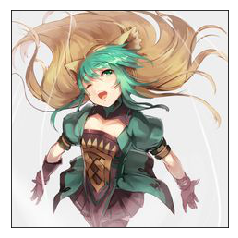

torch.Size([3, 224, 224])
331453-Fate_Series-Saber_Lily-748x1008.png

image:  331453-Fate_Series-Saber_Lily-748x1008.png
tensor([[0.9997, 0.0003]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0008, 0.0002, 0.9988, 0.0002]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0007, 0.9903, 0.0090]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0062, 0.0508, 0.0006, 0.0042, 0.7683, 0.0119, 0.0277, 0.0129, 0.1174]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.7055, 0.0835, 0.1129, 0.1878, 0.4561, 0.2013, 0.2164, 0.6417]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'silver', 'blue']


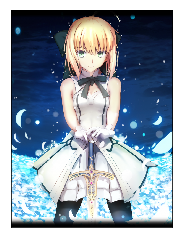

torch.Size([3, 224, 224])
arthur1.jpg

image:  arthur1.jpg
tensor([[0.5038, 0.4962]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0039, 0.0001, 0.9957, 0.0003]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[8.3834e-07, 9.9751e-01, 2.4891e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[6.9565e-15, 1.6137e-09, 9.2713e-11, 4.9960e-10, 1.0000e+00, 2.3527e-09,
         3.9497e-09, 9.4373e-10, 4.9624e-11]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.1785, 0.0768, 0.0155, 0.0479, 0.7273, 0.3132, 0.9781, 0.8783]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'silver', 'blue']


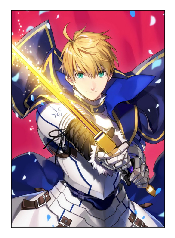

torch.Size([3, 224, 224])
arthur2.jpg

image:  arthur2.jpg
tensor([[0.9836, 0.0164]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0000, 0.0001, 0.9998, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0003, 0.9968, 0.0029]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.3436e-06, 6.2680e-06, 1.4614e-06, 5.2222e-06, 9.9994e-01, 1.0319e-05,
         7.8120e-06, 1.7503e-05, 6.1990e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.4497, 0.0200, 0.0671, 0.1555, 0.5209, 0.3708, 0.4996, 0.8587]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['silver', 'blue', 'gold']


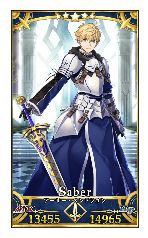

torch.Size([3, 224, 224])
arturia1.png

image:  arturia1.png
tensor([[0.9997, 0.0003]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.2636, 0.1198, 0.4893, 0.1274]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0060, 0.9933, 0.0007]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0001, 0.0127, 0.0002, 0.0127, 0.9612, 0.0001, 0.0129, 0.0001, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.2274, 0.1398, 0.0185, 0.4530, 0.1277, 0.8607, 0.7565, 0.3534]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['purple', 'gold', 'black']


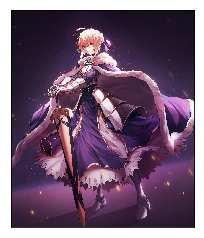

torch.Size([3, 224, 224])
gilgamesh.png

image:  gilgamesh.png
tensor([[0.0778, 0.9222]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[4.3600e-06, 5.5718e-03, 9.9440e-01, 1.9884e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.1279, 0.8372, 0.0350]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.8675e-06, 1.0479e-04, 7.4532e-03, 5.3598e-06, 9.8853e-01, 6.4502e-04,
         1.1691e-04, 3.0426e-03, 1.0458e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.3634, 0.0226, 0.3111, 0.1892, 0.8983, 0.0699, 0.9732, 0.5034]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'blue', 'silver']


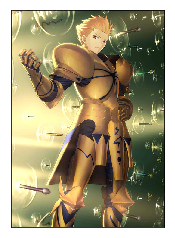

torch.Size([3, 224, 224])
gilgamesh2.jpg

image:  gilgamesh2.jpg
tensor([[0.5283, 0.4717]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0001, 0.0070, 0.9928, 0.0002]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0727, 0.9078, 0.0195]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0009, 0.0084, 0.0152, 0.0000, 0.9610, 0.0001, 0.0002, 0.0128, 0.0014]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.2928, 0.3356, 0.2589, 0.3460, 0.4940, 0.1385, 0.9837, 0.1152]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'blue', 'black']


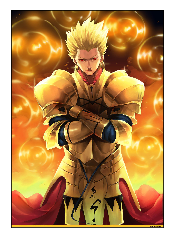

torch.Size([3, 224, 224])
gilgamesh3.jpg

image:  gilgamesh3.jpg
tensor([[0.2369, 0.7631]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.0003, 0.0014, 0.9979, 0.0004]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0123, 0.9486, 0.0391]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.2213, 0.3080, 0.0273, 0.0005, 0.3736, 0.0002, 0.0001, 0.0465, 0.0224]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.3772, 0.9305, 0.1625, 0.3056, 0.2725, 0.1136, 0.7939, 0.1093]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'gold', 'white']


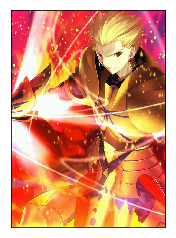

torch.Size([3, 224, 224])
gilgamesh4.jpg

image:  gilgamesh4.jpg
tensor([[0.0055, 0.9945]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.1900, 0.3208, 0.0926, 0.3966]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.0034, 0.5995, 0.3971]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.3627e-06, 1.2578e-04, 7.7997e-02, 7.1669e-04, 9.0702e-01, 9.8108e-03,
         1.2733e-03, 1.6634e-03, 1.3924e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.2680, 0.0536, 0.1774, 0.2108, 0.8976, 0.0523, 0.9671, 0.4564]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'blue', 'silver']


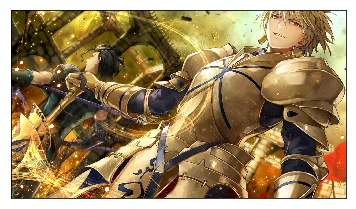

torch.Size([3, 224, 224])
ishtar1.jpg

image:  ishtar1.jpg
tensor([[0.9974, 0.0026]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.2722, 0.0024, 0.0001, 0.7252]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.0633, 0.0353, 0.9014]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[0.0015, 0.0008, 0.0065, 0.0008, 0.9034, 0.0157, 0.0422, 0.0008, 0.0284]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.7714, 0.0448, 0.1423, 0.3358, 0.8179, 0.1924, 0.5711, 0.1088]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['blue', 'white', 'gold']


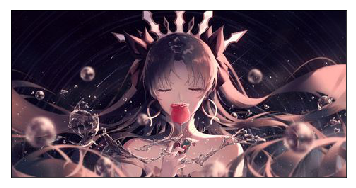

torch.Size([3, 224, 224])
ishtar2.jpg

image:  ishtar2.jpg
tensor([[0.0001, 0.9999]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.1574, 0.1011, 0.3063, 0.4352]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.0122, 0.0124, 0.9754]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[1.9155e-04, 1.8954e-05, 4.8867e-03, 2.7029e-04, 9.9171e-01, 1.9404e-03,
         3.2135e-06, 5.8548e-04, 3.9046e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.6810, 0.5213, 0.2025, 0.4225, 0.1839, 0.0390, 0.4876, 0.4364]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'red', 'gold']


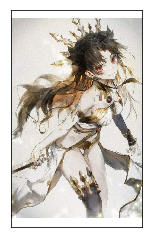

torch.Size([3, 224, 224])
ishtar3.png

image:  ishtar3.png
tensor([[0.9994, 0.0006]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.9052, 0.0008, 0.0001, 0.0939]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[0.0009, 0.3904, 0.6088]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[0.0263, 0.1490, 0.0032, 0.4261, 0.0001, 0.0078, 0.1393, 0.0011, 0.2472]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LE']
tensor([[0.3500, 0.7258, 0.2119, 0.5791, 0.5609, 0.1651, 0.0451, 0.1474]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'black', 'blue']


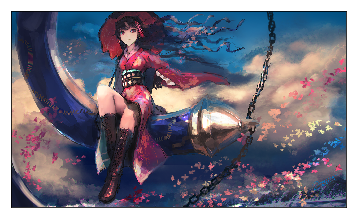

torch.Size([3, 224, 224])
ishtar4.jpg

image:  ishtar4.jpg
tensor([[0.9989, 0.0011]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.2693, 0.0020, 0.0000, 0.7287]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.3352, 0.0371, 0.6277]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[6.3326e-05, 6.2470e-05, 4.5587e-04, 5.8574e-06, 9.9652e-01, 1.1061e-04,
         2.3821e-03, 2.8098e-05, 3.7457e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.6650, 0.0574, 0.1162, 0.3487, 0.8810, 0.1979, 0.9420, 0.0356]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'blue', 'white']


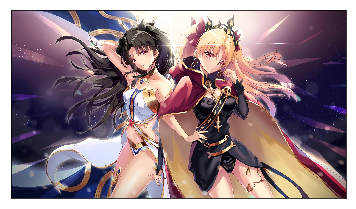

torch.Size([3, 224, 224])
jalter1.jpg

image:  jalter1.jpg
tensor([[0.4990, 0.5010]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.0050, 0.0349, 0.0288, 0.9313]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.0550, 0.4780, 0.4670]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0012, 0.0011, 0.0582, 0.8041, 0.0917, 0.0009, 0.0379, 0.0043, 0.0007]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LE']
tensor([[0.0971, 0.0909, 0.1842, 0.8413, 0.3592, 0.2980, 0.7893, 0.1322]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['black', 'gold', 'blue']


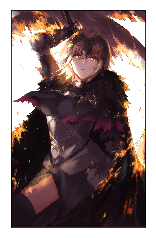

torch.Size([3, 224, 224])
jalter2.jpg

image:  jalter2.jpg
tensor([[0.9991, 0.0009]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0015, 0.0009, 0.9693, 0.0284]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0000, 0.9998, 0.0002]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.2080, 0.0037, 0.0001, 0.7801, 0.0010, 0.0000, 0.0046, 0.0010, 0.0016]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LE']
tensor([[0.0373, 0.1902, 0.0994, 0.8672, 0.0723, 0.7646, 0.0677, 0.4253]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['black', 'purple', 'silver']


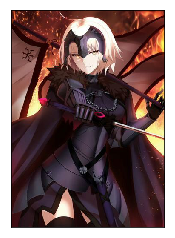

torch.Size([3, 224, 224])
jalter3.jpg

image:  jalter3.jpg
tensor([[0.9237, 0.0763]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0122, 0.0027, 0.9679, 0.0172]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0004, 0.9986, 0.0010]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[9.4101e-01, 5.8854e-03, 1.3389e-04, 5.1747e-02, 2.1305e-07, 3.5010e-06,
         4.8791e-05, 1.3117e-04, 1.0389e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CE']
tensor([[0.0694, 0.9093, 0.0878, 0.7791, 0.1755, 0.4576, 0.0395, 0.2439]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'black', 'purple']


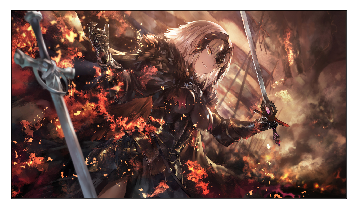

torch.Size([3, 224, 224])
larturia.png

image:  larturia.png
tensor([[0.9839, 0.0161]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0085, 0.0017, 0.9893, 0.0005]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[9.4400e-07, 9.9996e-01, 4.3458e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[2.1655e-08, 1.4084e-05, 2.1057e-06, 1.5037e-06, 9.9961e-01, 8.6421e-05,
         1.0987e-05, 1.3174e-05, 2.6005e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.6243, 0.0109, 0.0896, 0.0844, 0.8192, 0.1299, 0.6580, 0.8743]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['silver', 'blue', 'gold']


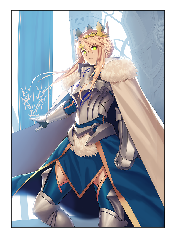

torch.Size([3, 224, 224])
merlin.png

image:  merlin.png
tensor([[0.0010, 0.9990]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.0742, 0.0010, 0.9246, 0.0002]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.9802, 0.0000, 0.0198]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['magic']
tensor([[1.3205e-06, 1.5848e-07, 2.5509e-06, 5.7539e-07, 8.7808e-01, 1.2179e-01,
         1.1611e-04, 1.1791e-05, 2.4961e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.9744, 0.0385, 0.0317, 0.0793, 0.8003, 0.4063, 0.0689, 0.3837]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'blue', 'purple']


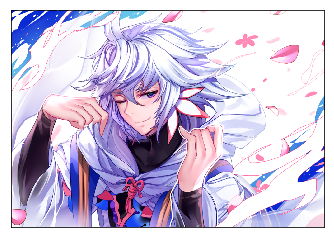

torch.Size([3, 224, 224])
morderd1.png

image:  morderd1.png
tensor([[0.9982, 0.0018]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.8875, 0.0015, 0.0726, 0.0384]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[0.0002, 0.9982, 0.0016]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.5396, 0.1925, 0.0012, 0.0940, 0.0008, 0.0005, 0.0161, 0.0007, 0.1548]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CE']
tensor([[0.2819, 0.7961, 0.0763, 0.6393, 0.2303, 0.4033, 0.0834, 0.2348]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'black', 'purple']


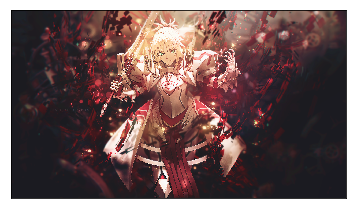

torch.Size([3, 224, 224])
musashi.jpg

image:  musashi.jpg
tensor([[0.9997, 0.0003]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.9983, 0.0004, 0.0012, 0.0002]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[2.9034e-06, 9.9882e-01, 1.1809e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[4.6251e-05, 8.8489e-01, 1.6730e-05, 2.5556e-02, 9.4757e-07, 1.1339e-04,
         7.9276e-02, 1.3846e-04, 9.9575e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CG']
tensor([[0.0748, 0.9663, 0.2217, 0.5688, 0.0186, 0.5991, 0.1999, 0.1496]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'purple', 'black']


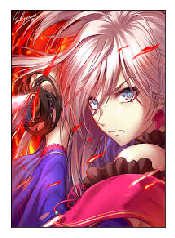

torch.Size([3, 224, 224])
musashi2.jpg

image:  musashi2.jpg
tensor([[9.9999e-01, 8.5260e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.9998, 0.0001, 0.0000, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[0.0001, 0.9998, 0.0001]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[3.8110e-04, 9.9062e-01, 3.0353e-06, 4.5052e-05, 3.0820e-06, 2.3486e-05,
         6.7411e-04, 1.5911e-05, 8.2373e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CG']
tensor([[0.2721, 0.9686, 0.1228, 0.1221, 0.0547, 0.6981, 0.2549, 0.1002]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['red', 'purple', 'white']


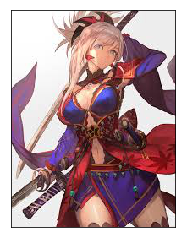

torch.Size([3, 224, 224])
okita.jpg

image:  okita.jpg
tensor([[0.9873, 0.0127]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.9959, 0.0005, 0.0002, 0.0034]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[9.3782e-07, 9.9980e-01, 1.9418e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.3893e-06, 3.5534e-06, 6.8569e-06, 1.0877e-06, 4.8283e-07, 1.5385e-03,
         1.8256e-05, 2.9730e-06, 9.9843e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['TN']
tensor([[0.9453, 0.0132, 0.7367, 0.3725, 0.9923, 0.0051, 0.0581, 0.2450]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['blue', 'white', 'green']


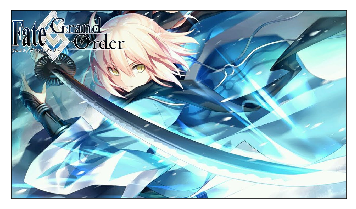

torch.Size([3, 224, 224])
okita2.jpg

image:  okita2.jpg
tensor([[0.9973, 0.0027]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.9966, 0.0006, 0.0024, 0.0004]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Asia']
tensor([[3.2090e-06, 9.9979e-01, 2.0920e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.5236e-05, 1.0995e-04, 1.0360e-05, 2.0253e-06, 1.7099e-05, 6.5112e-04,
         3.4122e-04, 1.6919e-05, 9.9884e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['TN']
tensor([[0.8743, 0.0482, 0.6422, 0.5869, 0.8233, 0.0160, 0.2121, 0.2886]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'blue', 'green']


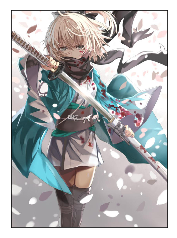

torch.Size([3, 224, 224])
ozy.jpg

image:  ozy.jpg
tensor([[0.0165, 0.9835]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.0001, 0.9971, 0.0015, 0.0013]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Egypt']
tensor([[9.5712e-01, 8.0677e-06, 4.2869e-02]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['magic']
tensor([[5.0524e-05, 9.8013e-05, 9.8572e-01, 6.2601e-06, 7.3401e-04, 8.0793e-03,
         4.8881e-04, 4.7056e-03, 1.2131e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['CN']
tensor([[0.5936, 0.1070, 0.4790, 0.2589, 0.5633, 0.0923, 0.9620, 0.1405]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['gold', 'white', 'blue']


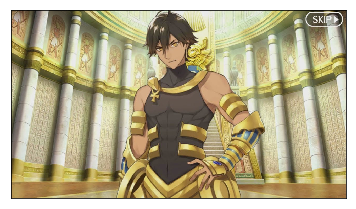

torch.Size([3, 224, 224])
saber1.jpg

image:  saber1.jpg
tensor([[0.9993, 0.0007]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0000, 0.0000, 0.9999, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[1.2288e-06, 9.9983e-01, 1.7341e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[2.0343e-10, 1.2557e-06, 2.9008e-08, 2.7827e-07, 1.0000e+00, 2.9480e-07,
         2.0902e-06, 7.1355e-07, 1.2131e-07]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.2291, 0.0189, 0.0467, 0.0644, 0.7514, 0.3115, 0.8595, 0.8828]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['silver', 'gold', 'blue']


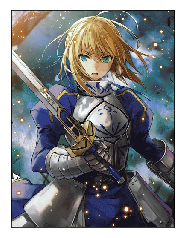

torch.Size([3, 224, 224])
saber2.jpg

image:  saber2.jpg
tensor([[1.0000e+00, 6.6159e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.1347, 0.0821, 0.7794, 0.0038]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0037, 0.9836, 0.0127]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0011, 0.3658, 0.0004, 0.0001, 0.0021, 0.0064, 0.0184, 0.0053, 0.6005]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['TN']
tensor([[0.9021, 0.1185, 0.2672, 0.0653, 0.4350, 0.1630, 0.3488, 0.3944]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'blue', 'silver']


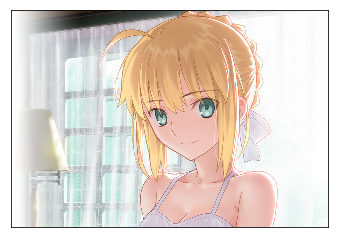

torch.Size([3, 224, 224])
saber3.jpg

image:  saber3.jpg
tensor([[0.9987, 0.0013]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0002, 0.0003, 0.9980, 0.0015]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[6.7371e-06, 9.9406e-01, 5.9311e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[7.5824e-07, 3.1893e-04, 4.6680e-05, 7.1728e-04, 9.9633e-01, 8.7091e-04,
         7.6726e-04, 2.4293e-04, 7.0438e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.4652, 0.0204, 0.0841, 0.0894, 0.9078, 0.2131, 0.2929, 0.8784]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['blue', 'silver', 'white']


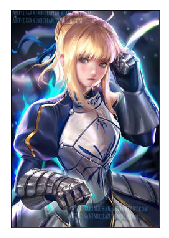

torch.Size([3, 224, 224])
saber4.png

image:  saber4.png
tensor([[0.9977, 0.0023]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[0.0319, 0.0282, 0.7079, 0.2320]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0000, 0.9999, 0.0001]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[0.0023, 0.0026, 0.0016, 0.9684, 0.0031, 0.0011, 0.0122, 0.0007, 0.0080]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LE']
tensor([[0.1724, 0.0336, 0.0606, 0.6162, 0.8170, 0.3590, 0.1415, 0.5288]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['blue', 'black', 'silver']


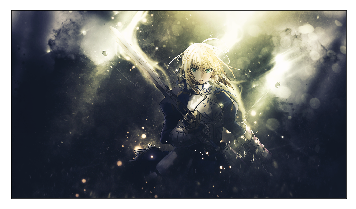

torch.Size([3, 224, 224])
santaalter.jpg

image:  santaalter.jpg
tensor([[0.9947, 0.0053]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[1.7801e-06, 5.4137e-06, 9.9999e-01, 1.3791e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0257, 0.9421, 0.0322]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[2.8564e-05, 7.5929e-05, 1.6560e-06, 1.3870e-05, 9.9952e-01, 1.1961e-04,
         8.8983e-05, 1.3993e-04, 1.6137e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.6613, 0.0624, 0.0399, 0.1816, 0.4662, 0.3884, 0.2394, 0.7264]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['silver', 'white', 'blue']


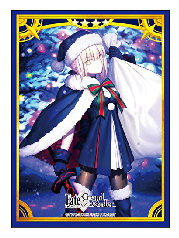

torch.Size([3, 224, 224])
scattach.png

image:  scattach.png
tensor([[0.9999, 0.0001]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Female']
tensor([[6.7762e-07, 7.1791e-05, 9.9975e-01, 1.7719e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[0.0001, 0.9999, 0.0000]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[3.8201e-03, 5.4596e-03, 6.3255e-05, 3.4235e-03, 9.8613e-01, 1.8545e-06,
         1.6266e-04, 8.8451e-04, 5.7898e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.0721, 0.1528, 0.0359, 0.5079, 0.1911, 0.7306, 0.5934, 0.5137]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['purple', 'gold', 'silver']


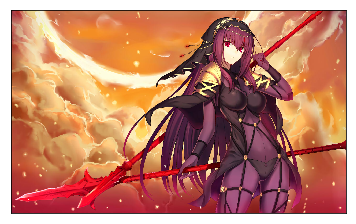

torch.Size([3, 224, 224])
stheno.jpg

image:  stheno.jpg
tensor([[0.0269, 0.9731]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.2433, 0.0006, 0.7560, 0.0001]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Europe']
tensor([[5.6211e-02, 1.4191e-06, 9.4379e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['ranged']
tensor([[3.2283e-10, 1.6068e-08, 2.5631e-08, 1.1528e-07, 6.4940e-01, 3.5042e-01,
         1.7629e-04, 1.0965e-06, 9.5897e-08]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LG']
tensor([[0.9894, 0.0176, 0.0524, 0.0204, 0.6464, 0.2947, 0.0154, 0.8816]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['white', 'silver', 'blue']


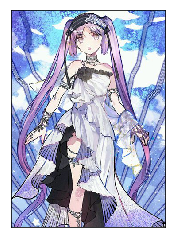

torch.Size([3, 224, 224])
wlop.jpg

image:  wlop.jpg
tensor([[5.7973e-06, 9.9999e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['Male']
tensor([[0.1089, 0.0172, 0.3124, 0.5614]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['Middle East']
tensor([[0.0013, 0.8304, 0.1683]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['melee']
tensor([[1.7264e-05, 4.7625e-06, 2.8890e-03, 8.6376e-01, 1.0520e-01, 2.7556e-02,
         5.6188e-05, 2.1694e-04, 2.9830e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
['LE']
tensor([[0.2164, 0.0399, 0.1123, 0.6580, 0.8735, 0.0499, 0.0895, 0.7705]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
['blue', 'silver', 'black']


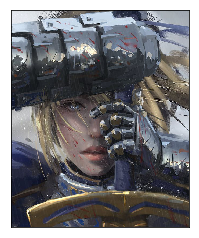

In [18]:
from os import listdir
from matplotlib.pyplot import imshow

%matplotlib inline
#pil_im = Image.open('data/empire.jpg', 'r')

test = listdir('test/')
    
for i in test:
    

    image = image_loader(i)
    y_pred = model1(image)
    print(i)
    print('')
    print('image: ', i )
    print(extract_label(gender,y_pred[0]))
    print(extract_label(region,y_pred[1]))
    print(extract_label(fighting_style,y_pred[2]))
    print(extract_label(alignment,y_pred[3]))
    print(extract_label(colors,y_pred[4],3))
    pil_im = Image.open('test/'+i)
    
    plt.imshow(np.asarray(pil_im))
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
    